In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict


from sklearn.preprocessing import OneHotEncoder


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import warnings

warnings.filterwarnings('ignore')

### Dataset Exploration

In [2]:
data = pd.read_csv('itsm.csv')

In [3]:
data.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,incident,KM0000553,closed,26.0,05-02-2012 13:32,NaN,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,incident,KM0000611,closed,33.0,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,request for information,KM0000339,closed,3.0,29-03-2012 12:36,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,incident,KM0000611,closed,13.0,17-07-2012 11:49,NaN,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,incident,KM0000611,closed,2.0,10-08-2012 11:01,NaN,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN


In [4]:
data.CI_Cat.fillna('application',inplace=True)
data.CI_Subcat.fillna('One View Reporting',inplace=True)

In [5]:
data.CI_Cat.unique()

array(['subapplication', 'application', 'computer', 'displaydevice',
       'software', 'storage', 'database', 'hardware', 'officeelectronics',
       'networkcomponents', 'applicationcomponent', 'Phone'], dtype=object)

In [6]:
data.CI_Cat.value_counts()

application             33011
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: CI_Cat, dtype: int64

### Segregating the data

In [7]:

data['Open_Time']=pd.to_datetime(data.Open_Time,utc=True,format='%d-%m-%Y %H:%M')

In [8]:
data2=data[['CI_Cat','Category','Open_Time']]

Let's isolate the 'application' data from the CI_Cat and check out the category of incidents 

In [9]:
def get_timeseries(field,df):
    """
    Returns a timeseries data with respect to the corresponding CI_Cat values
    in the dataframe
    
    """
    
    df1=df.loc[df['CI_Cat']==field,['Category','Open_Time']]
    sort_data =df1.sort_values('Open_Time',ignore_index=True)
    sort_data=sort_data.set_index('Open_Time')
    return sort_data


def get_train_test(ts1,index):
    '''
    Returns the two timeseries datas(training and testing) obtained after splitting, 
    OneHotEncoding and resampling
    
    '''
    X = ts1[index:]
    size=int(len(X)*0.80)
    x_train_full = X[:size]
    x_test_full = X[size:]
    OH = OneHotEncoder(sparse=False,handle_unknown='ignore')
    x_train_OH=pd.DataFrame(OH.fit_transform(x_train_full[['Category']]),columns=OH.categories_[0].tolist(),index=x_train_full.index)
    x_test_OH=pd.DataFrame(OH.transform(x_test_full[['Category']]),columns=OH.categories_[0].tolist(),index=x_test_full.index) 
    train_x=pd.DataFrame(x_train_OH['incident'])
    test_x = pd.DataFrame(x_test_OH['incident'])
    
    # Resample the data into frequency of days

    train=train_x.resample('D').sum()
    test= test_x.resample('D').sum()
    
    return ( train,test)



def plot_timeseries(train,test):
    '''
    PLots the timeseries data both as scatterplot and line-plot
    
    '''
    plt.subplots(1,1)
    sns.scatterplot(x=train.index,y=train.incident.values)
    plt.title('Incident vs Year scatterplot ')
    #plt.show()
    
    plt.subplots(1,1)
    plt.plot(train,label='train')
    plt.plot(test,label='test')
    plt.title('Timeseries data')
    plt.legend(loc='best')
    plt.show()

In [10]:
fld= 'application'
ts_data=get_timeseries('application',data2)
ts_data.head()

,Category
Open_Time,
2012-03-12 15:44:00+00:00,incident
2012-03-29 12:36:00+00:00,request for information
2012-07-17 11:49:00+00:00,incident
2012-08-10 11:01:00+00:00,incident
2012-08-10 11:27:00+00:00,incident


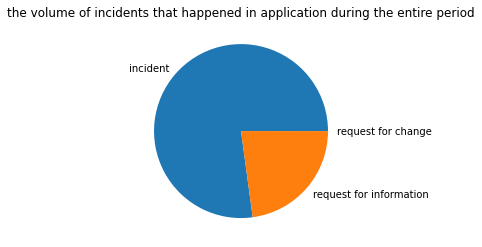

In [11]:
plt.pie(ts_data.Category.value_counts(),labels=ts_data.Category.unique())
plt.title('the volume of incidents that happened in {} during the entire period'.format(fld))
plt.show()

###### To determine the size of the dataset

* the records are selected from where we have relevant and enough datas to work with.
* the whole timeseries data is plotted and needed index is obtained from the graph

(array(15949.), array(16161.))

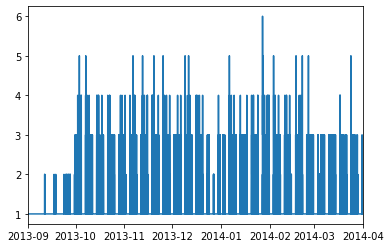

In [38]:
df=pd.DataFrame(ts_data.groupby('Open_Time')['Category'].transform('count'),index=ts_data.index)
plt.plot(df)
plt.xlim('2013-09','2014-04')

* values bulks up in the month of October 2013.
* Hence our index starts from that month.

In [39]:
ts_data['2013-10']

,Category
Open_Time,
2013-10-01 07:33:00+00:00,incident
2013-10-01 07:33:00+00:00,incident
2013-10-01 07:45:00+00:00,incident
2013-10-01 08:00:00+00:00,incident
2013-10-01 08:14:00+00:00,request for information
2013-10-01 08:18:00+00:00,incident
2013-10-01 08:18:00+00:00,incident
2013-10-01 08:18:00+00:00,request for information
2013-10-01 08:23:00+00:00,request for information


In [40]:
ind = '2013-10-01 07:33:00+00:00'
X_train,X_test= get_train_test(ts_data,ind)

print('The size of train and test datas are: \n X_train = {} \n X_test = {}'.format(X_train.shape,X_test.shape))

The size of train and test datas are: 
 X_train = (141, 1) 
 X_test = (42, 1)


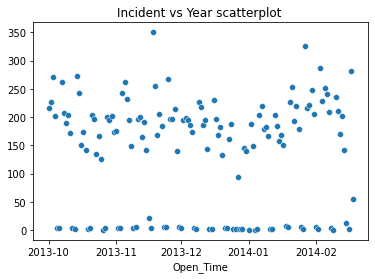

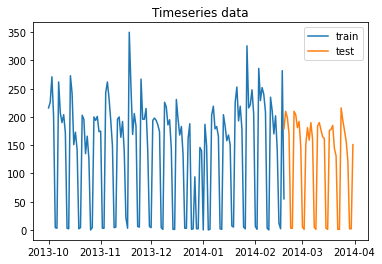

In [41]:
plot_timeseries(X_train,X_test)

#####  Checking Stationarity using Dickey-fuller test

In [42]:
from statsmodels.tsa.stattools import adfuller

In [43]:
print('Dickey-Fuller Test:')
dftest=adfuller((X_train))
dfoutput = pd.Series(dftest[0:4],index=['Test_Statistic',
                                        'p-value','#Lags used','Number of Observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Dickey-Fuller Test:
Test_Statistic                  -2.224996
p-value                          0.197299
#Lags used                      13.000000
Number of Observations used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


* the test_statistic is above 5% critical value 
* p-value > 0.05
* It can inferred that the timeseries is not stationary.
* Hence we go for a differencing of 1

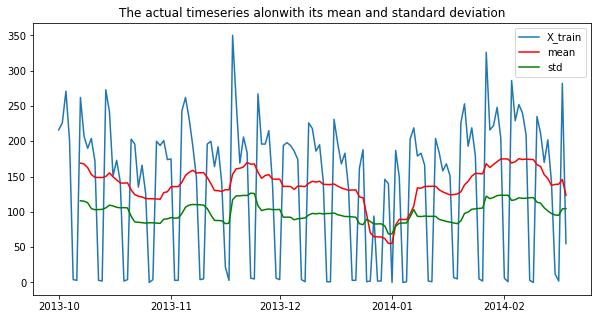

In [44]:
# checking whether the data is stationary or not, visually

roll_mean = (X_train).rolling(7).mean()
roll_std = (X_train).rolling(7).std()

plt.figure(figsize=(10,5))
plt.title('The actual timeseries alonwith its mean and standard deviation')
plt.plot((X_train),label='X_train')
plt.plot(roll_mean,'r',label='mean')
plt.plot(roll_std,'g',label='std')
plt.legend(loc='best')
plt.show()

###### Differencing twice

In [47]:

x_moving_avg_diff = (X_train)-roll_mean
x_moving_avg_diff.dropna(inplace=True)
roll_mean2 = (x_moving_avg_diff).rolling(7).mean()
x_moving_avg_diff2 = x_moving_avg_diff-roll_mean2
x_moving_avg_diff2.dropna(inplace=True)

print('Dickey-Fuller Test:')
dftest=adfuller(x_moving_avg_diff2)
dfoutput = pd.Series(dftest[0:4],index=['Test_Statistic',
                                        'p-value','#Lags used','Number of Observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Dickey-Fuller Test:
Test_Statistic                  -3.620865
p-value                          0.005374
#Lags used                      13.000000
Number of Observations used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


* The test_statistic is below the critical 1% 
* p-value < 0.05
* The series can be said to have been made statonary.

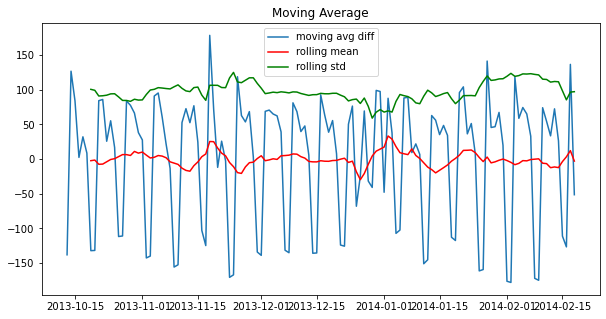

In [48]:
# Moving Average with differencing of 2 visually

plt.figure(figsize=(10,5))
plt.plot(x_moving_avg_diff2,label='moving avg diff')
plt.plot((x_moving_avg_diff2).rolling(7).mean(),'r',label='rolling mean')
plt.plot((x_moving_avg_diff2).rolling(7).std(),'g',label='rolling std')
plt.title('Moving Average')
plt.legend(loc='best')
plt.show()

###### Checking the auto correlation plot to determine the ARIMA order

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

######  ACF plot

<Figure size 576x360 with 0 Axes>

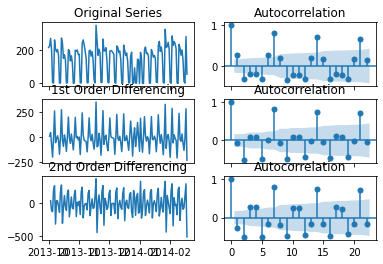

In [50]:
# Original Series
plt.figure(figsize=(8,5))
fig,axs = plt.subplots(3, 2,sharex='col')
axs[0,0].plot(X_train.incident)
axs[0,0].set_title('Original Series')
plot_acf(X_train.incident, ax=axs[0,1])

# 1st Differencing
axs[1,0].plot(X_train.incident.diff())
axs[1,0].set_title('1st Order Differencing')
plot_acf(X_train.incident.diff().dropna(), ax=axs[1,1])

# 2nd Differencing
axs[2,0].plot(X_train.incident.diff().diff())
axs[2,0].set_title('2nd Order Differencing')
plot_acf(X_train.incident.diff().diff().dropna(), ax=axs[2,1])


plt.show()

######  PACF plot

<Figure size 576x360 with 0 Axes>

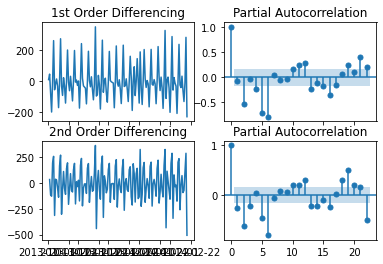

In [51]:
# Original Series
plt.figure(figsize=(8,5))
fig,axs = plt.subplots(2, 2,sharex='col')

# 1st Differencing
axs[0,0].plot(X_train.diff())
axs[0,0].set_title('1st Order Differencing')
plot_pacf(X_train.diff().dropna(), ax=axs[0,1])

# 2nd Differencing
axs[1,0].plot(X_train.diff().diff())
axs[1,0].set_title('2nd Order Differencing')
plot_pacf(X_train.diff().diff().dropna(), ax=axs[1,1])

plt.show()

* Negative Correlation is observed at lag 1.
* Hence we use MA model
* difference be 1, d=1
* q=6

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

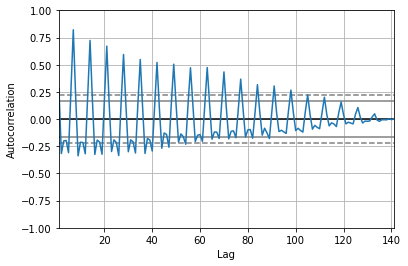

In [53]:
autocorrelation_plot((X_train))

### ARIMA

In [113]:
from statsmodels.tsa.arima.model import ARIMA

###### ARIMA WITH DIFFERENCING 1
* order = (21,1,21)

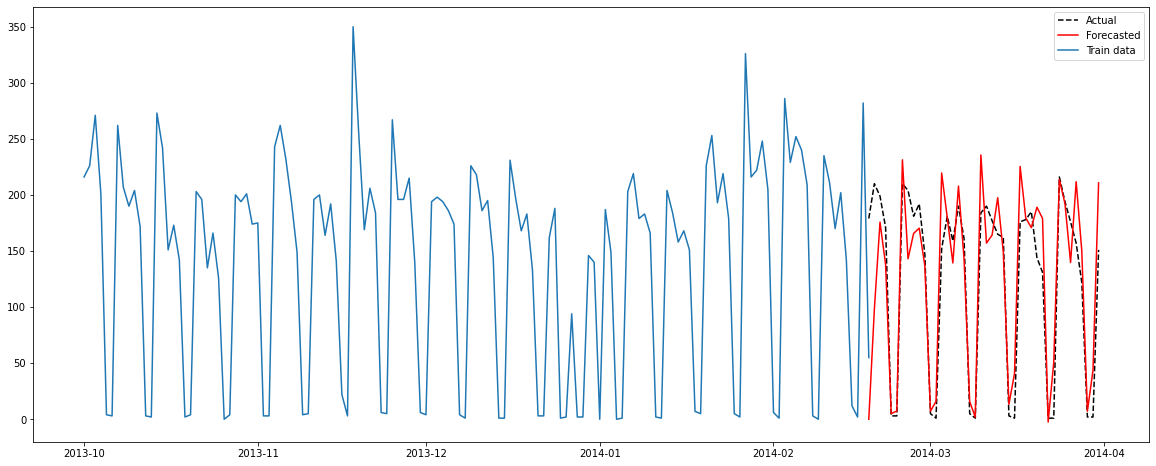



The RMSE :  44.68


In [141]:
y_hat = X_test.copy()
model = ARIMA(X_train,order=(21,1,21)).fit()
y_hat['Arima'] = model.forecast(len(X_test))
y_hat['Arima'].fillna(0,inplace=True)

plt.figure(figsize=(20,8))
plt.plot(X_test,'k--',label='Actual')
plt.plot(y_hat['Arima'],'r',label='Forecasted')
plt.plot(X_train,label='Train data')
plt.legend(loc='best')
plt.show()

error = sqrt(mean_squared_error(X_test,y_hat.Arima))
print('\n\nThe RMSE : ',round(error,ndigits=2))

<Figure size 576x360 with 0 Axes>

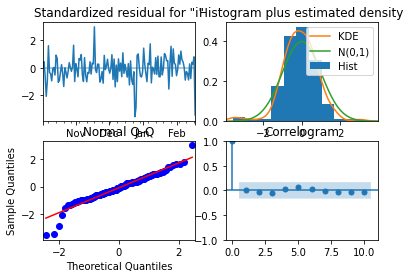

In [76]:
plt.figure(figsize=(8,5))
model.plot_diagnostics()
plt.show()

In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               incident   No. Observations:                  141
Model:               ARIMA(21, 1, 21)   Log Likelihood                -706.390
Date:                Fri, 27 Aug 2021   AIC                           1498.780
Time:                        16:12:30   BIC                           1625.270
Sample:                    10-01-2013   HQIC                          1550.182
                         - 02-18-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3016      0.920     -0.328      0.743      -2.105       1.502
ar.L2          0.0910      0.929      0.098      0.922      -1.730       1.912
ar.L3         -0.2735      1.027     -0.266      0.790      -2.287       1.740
ar.L4          0.0855      1.091      0.078      0.938      -2.053       2.224
ar.L5          0.3532      0.954      0.370      0.711      -1.517       2.224
ar.L6          0.1817      0.888      0.205      0.838      -1.558       1.921
ar.L7          0.0569      0.784      0.073      0.942      -1.479       1.593
ar.L8         -0.0984      0.623     -0.158      0.874      -1.319       1.122
ar.L9         -0.0256      0.671     -0.038      0.970      -1.340       1.289
ar.L10        -0.2137      0.859     -0.249      0.804      -1.898       1.470
ar.L11        -0.2660      0.639     -0.416      0.677      -1.519       0.987
ar.L12        -0.3040      0.544     -0.559      0.576      -1.370       0.762
ar.L13        -0.1541      0.583     -0.264      0.791      -1.296       0.988
ar.L14         0.2575      0.564      0.456      0.648      -0.849       1.364
ar.L15         0.1500      0.547      0.274      0.784      -0.922       1.222
ar.L16        -0.2928      0.617     -0.475      0.635      -1.501       0.916
ar.L17         0.1693      0.583      0.290      0.772      -0.973       1.312
ar.L18         0.0296      0.738      0.040      0.968      -1.417       1.476
ar.L19        -0.4162      0.548     -0.759      0.448      -1.491       0.659
ar.L20        -0.1656      0.490     -0.338      0.736      -1.127       0.796
ar.L21         0.3458      0.452      0.765      0.444      -0.540       1.232
ma.L1         -0.2471      1.317     -0.188      0.851      -2.829       2.335
ma.L2         -0.5547      0.986     -0.562      0.574      -2.488       1.378
ma.L3          0.1572      1.523      0.103      0.918      -2.828       3.143
ma.L4         -0.2538      1.417     -0.179      0.858      -3.031       2.523
ma.L5         -0.3292      1.522     -0.216      0.829      -3.312       2.653
ma.L6          0.1695      1.353      0.125      0.900      -2.483       2.822
ma.L7          0.5515      1.191      0.463      0.643      -1.782       2.885
ma.L8         -0.0955      1.089     -0.088      0.930      -2.230       2.039
ma.L9         -0.0557      1.752     -0.032      0.975      -3.490       3.378
ma.L10         0.1419      1.307      0.109      0.914      -2.421       2.704
ma.L11        -0.4125      0.666     -0.619      0.536      -1.719       0.894
ma.L12         0.1452      1.483      0.098      0.922      -2.762       3.052
ma.L13        -0.0672      1.290     -0.052      0.958      -2.595       2.461
ma.L14        -0.1838      1.086     -0.169      0.866      -2.313       1.945
ma.L15        -0.1216      1.436     -0.085      0.933      -2.937       2.694
ma.L16         0.4305      1.154      0.373      0.709      -1.832       2.693
ma.L17         0.0264      1.045      0.025      0.980      -2.022       2.075
ma

   ######  Arima with differencing=2
  * order = (14,2,16)

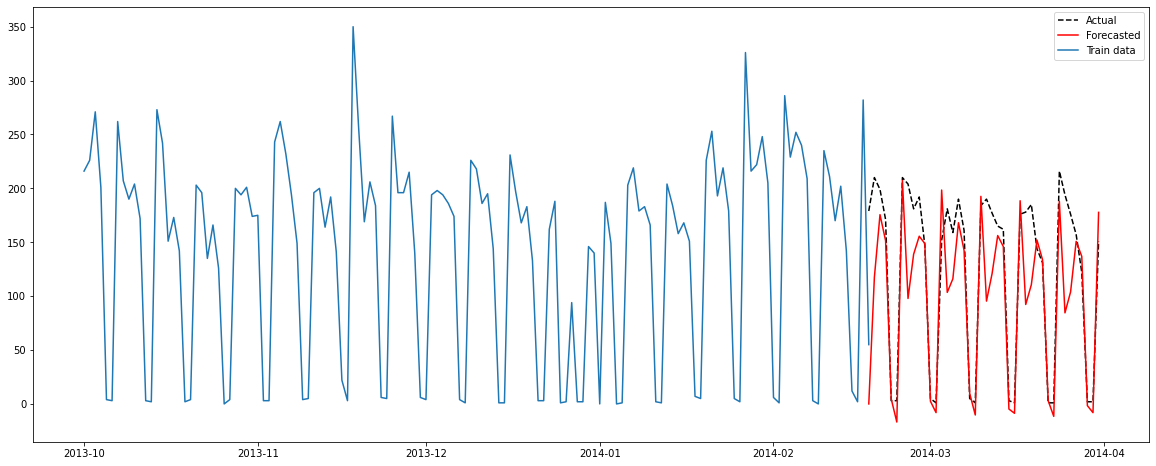



The RMSE :  51.72


In [139]:
y_hat = X_test.copy()
model = ARIMA(X_train,order=(14,2,16)).fit()
y_hat['Arima']=model.forecast(len(X_test))
y_hat['Arima'].fillna(0,inplace=True)

plt.figure(figsize=(20,8))
plt.plot(X_test,'k--',label='Actual')
plt.plot(y_hat.Arima,'r',label='Forecasted')
plt.plot(X_train,label='Train data')
plt.legend(loc='best')
plt.show()

error = sqrt(mean_squared_error(X_test.incident.values,y_hat.Arima.values))
print('\n\nThe RMSE : ',round(error,ndigits=2))

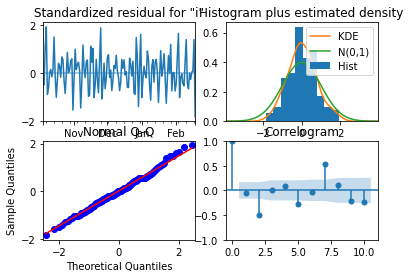

In [110]:
model.plot_diagnostics()
plt.show()

In [111]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               incident   No. Observations:                  141
Model:                 ARIMA(2, 3, 6)   Log Likelihood                -834.253
Date:                Fri, 27 Aug 2021   AIC                           1686.506
Time:                        16:22:36   BIC                           1712.852
Sample:                    10-01-2013   HQIC                          1697.212
                         - 02-18-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4469      0.002   -192.540      0.000      -0.451      -0.442
ar.L2         -1.0000      0.000  -2725.847      0.000      -1.001      -0.999
ma.L1         -1.2718      1.896     -0.671      0.502      -4.988       2.445
ma.L2          1.5375      0.582      2.640      0.008       0.396       2.679
ma.L3         -2.5868      0.385     -6.710      0.000      -3.342      -1.831
ma.L4          1.5166      0.692      2.192      0.028       0.161       2.873
ma.L5         -1.0592      1.602     -0.661      0.508      -4.198       2.080
ma.L6          0.8638      0.254      3.400      0.001       0.366       1.362
sigma2      1.344e+04      0.000   7.41e+07      0.000    1.34e+04    1.34e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.46   Prob(JB):                         0.78
Heteroskedasticity (H):               0.98   Skew:                             0.14
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.15e+23. Standard errors may be unstable.
"""

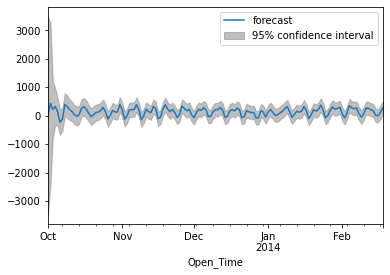

In [112]:
plot_predict(model)
plt.show()